In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

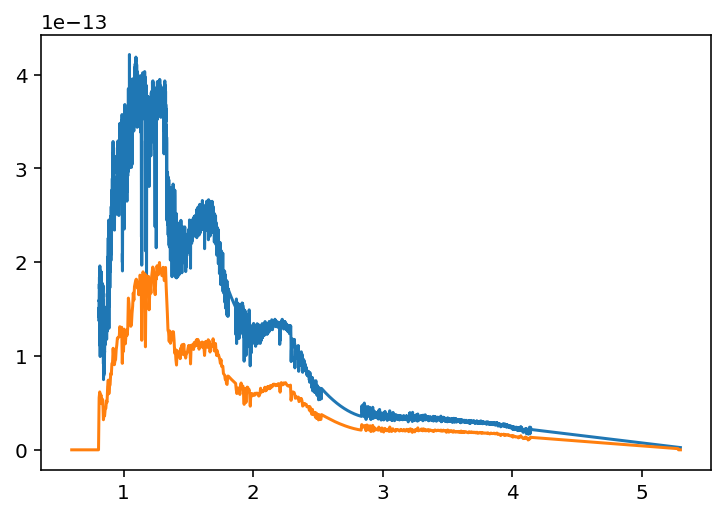

In [2]:
from libra import throughput, IRTFTemplate, quantum_efficiency

wavelengths = np.linspace(0.6, 5.3, 1000) * u.um

m8v = IRTFTemplate('M8V')
m5v = IRTFTemplate('M5V')
m2v = IRTFTemplate('M2V')
k2v = IRTFTemplate('K2V')

trans = throughput(wavelengths)
qe = quantum_efficiency(wavelengths)

plt.plot(m8v.wavelength, m8v.flux)
plt.plot(wavelengths, trans*m8v.interp_flux(wavelengths))

In [3]:
delta_lam = np.median(np.diff(wavelengths))

(m8v.interp_flux(wavelengths) * wavelengths * 10*u.s).to(u.mJy)

<Quantity [  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             1.28664729e+17,  1.43931630e+17,  1.232250

In [4]:
np.savetxt('M8Vspectrum.txt', np.vstack([wavelengths, 
                                         (m8v.interp_flux(wavelengths) * wavelengths * 
                                          10*u.s).to(u.mJy).value]).T)

In [5]:
m8v.header['J']

gain = 1  #  e- / ADU

In [6]:
from astropy.constants import h, c

In [7]:
dlam = np.median(np.diff(m8v.wavelength))
aperture = 0.5 * u.m**2
exp_time = 1000 * u.s
(m8v.flux * m8v.wavelength / h / c * aperture * dlam * exp_time).decompose()

<Quantity [ 141783.5846012 , 146157.76192966, 149619.78422235,...,
             16308.08533607,  16253.29648849,  16198.49694957]>

In [8]:
from libra import magnitudes

In [9]:
magnitudes['TRAPPIST-1']['J']

11.354

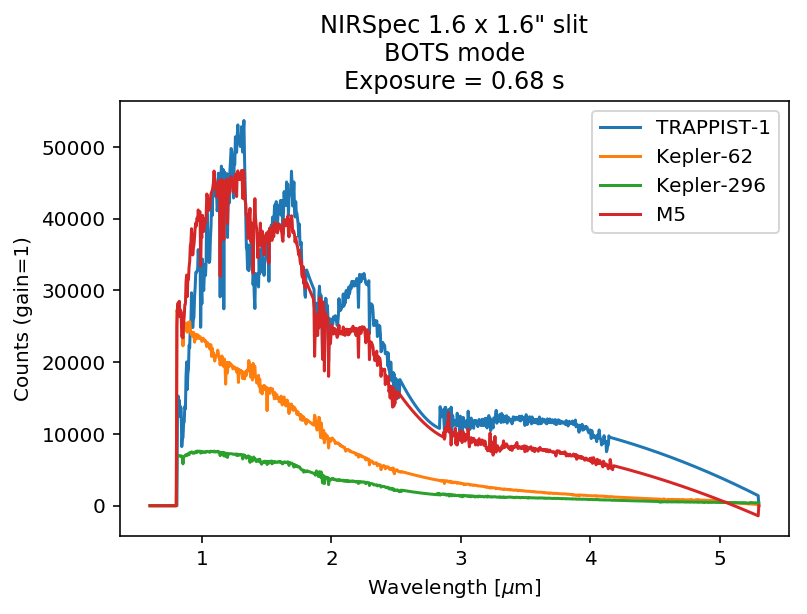

In [10]:
exp_time = 0.68*u.s
trappist_counts = m8v.n_photons(wavelengths, exp_time, J=magnitudes['TRAPPIST-1']['J'])
k62_counts = k2v.n_photons(wavelengths, exp_time, J=magnitudes['Kepler-62']['J'])
k296_counts = m2v.n_photons(wavelengths, exp_time, J=magnitudes['Kepler-296']['J'])
m5v_counts = m5v.n_photons(wavelengths, exp_time, J=magnitudes['TRAPPIST-1']['J'])

def observe(counts):
    return counts #* trans #* qe

plt.plot(wavelengths, observe(trappist_counts), label='TRAPPIST-1')
plt.plot(wavelengths, observe(k62_counts), label='Kepler-62')
plt.plot(wavelengths, observe(k296_counts), label='Kepler-296')

plt.plot(wavelengths, observe(m5v_counts), label='M5')


plt.title('NIRSpec 1.6 x 1.6" slit\nBOTS mode\nExposure = {0}'.format(exp_time))
plt.ylabel('Counts (gain=1)')
plt.xlabel('Wavelength [$\mu$m]')
plt.legend()
plt.savefig('saturation.pdf', bbox_inches='tight')

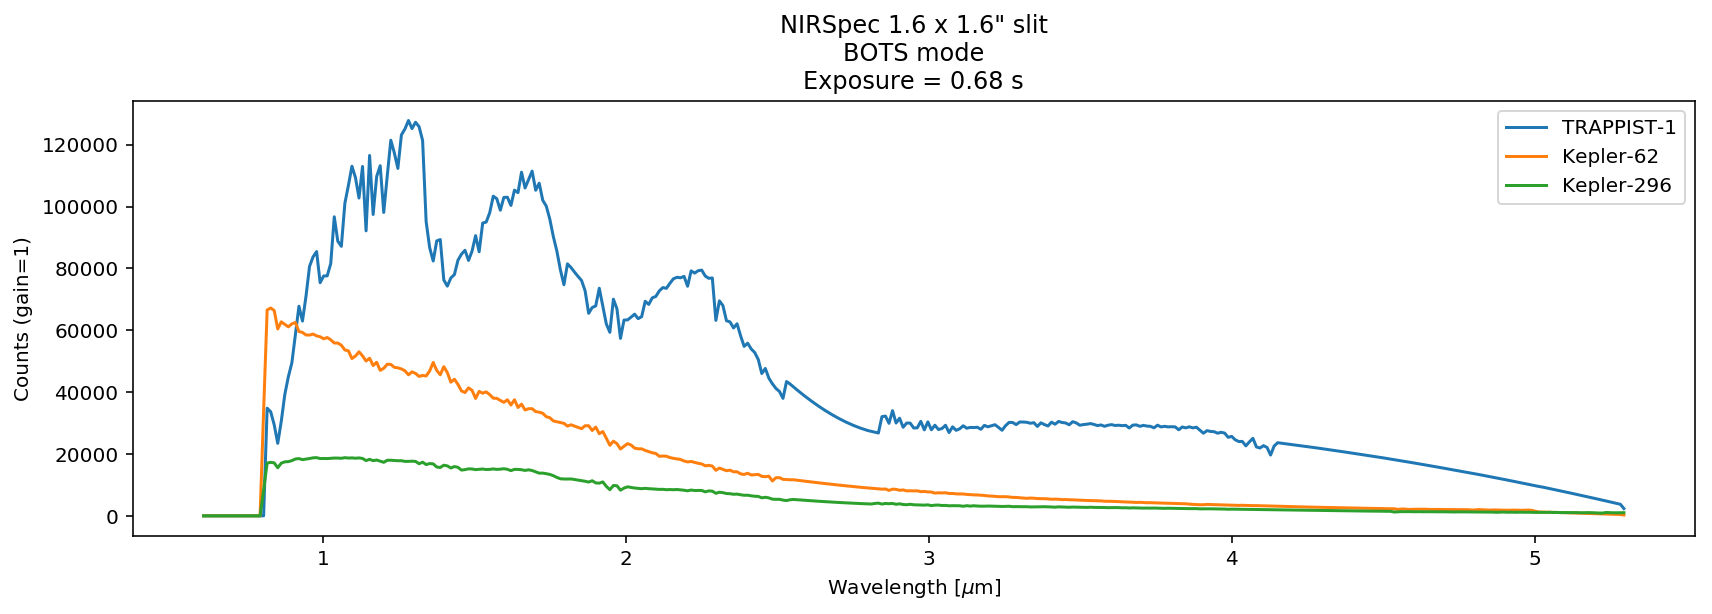

In [11]:
exp_time = 0.68*u.s
R = 100
central_wavelength = 2 # micron
delta_lambda = central_wavelength/R
#wavelengths = np.arange(0.6, 5.3, delta_lambda) * u.um
wavelengths = np.linspace(0.6, 5.3, 1000) * u.um

trappist_counts = m8v.n_photons(wavelengths, exp_time, J=magnitudes['TRAPPIST-1']['J'])
k62_counts = k2v.n_photons(wavelengths, exp_time, J=magnitudes['Kepler-62']['J'])
k296_counts = m2v.n_photons(wavelengths, exp_time, J=magnitudes['Kepler-296']['J'])

from scipy.stats import binned_statistic

def binned(counts):
    bins = np.linspace(0.6, 5.3, 404)
    bs = binned_statistic(wavelengths, observe(counts), bins=bins, 
                          statistic='sum')
    bs_count = binned_statistic(wavelengths, observe(counts), bins=bins, 
                                statistic='count')
    bin_centers = 0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])
    return bin_centers, bs.statistic / bs_count.statistic * np.mean(bs_count.statistic)

plt.figure(figsize=(14, 4))
plt.plot(*binned(trappist_counts), label='TRAPPIST-1')
plt.plot(*binned(k62_counts), label='Kepler-62')
plt.plot(*binned(k296_counts), label='Kepler-296')

#plt.plot(*binned(m5v_counts), label='M5V')

plt.title('NIRSpec 1.6 x 1.6" slit\nBOTS mode\nExposure = {0}'.format(exp_time))
plt.ylabel('Counts (gain=1)')
plt.xlabel('Wavelength [$\mu$m]')
plt.legend()
plt.savefig('saturation.pdf', bbox_inches='tight')

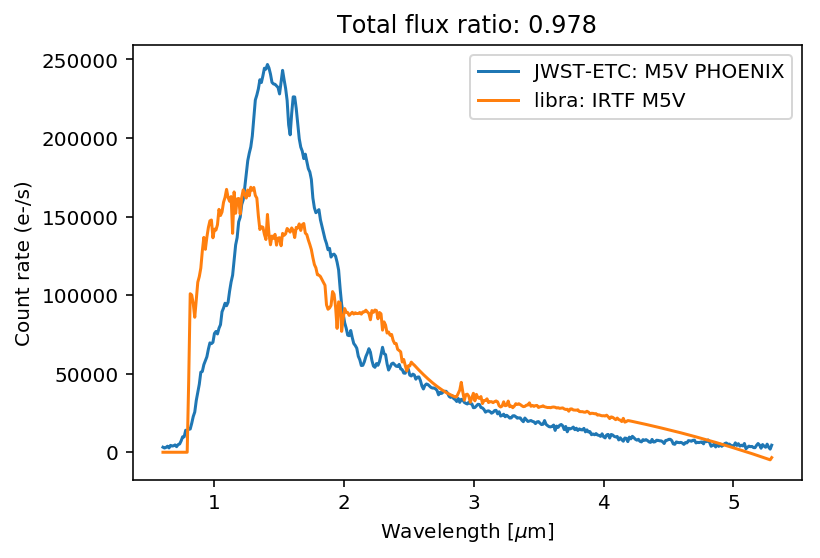

In [12]:
from astropy.io import fits

img = fits.getdata('/Users/bmmorris/Downloads/wb12253_c10_2018-01-16_19.13.22/image/image_detector.fits') # M5 phoenix 

wl, fl = binned(m5v_counts)

plt.plot(wl, np.sum(img, axis=0)/exp_time, label='JWST-ETC: M5V PHOENIX')
plt.plot(wl, fl/exp_time, label='libra: IRTF M5V')
plt.title("Total flux ratio: {0:.3f}".format(np.sum(img)/np.sum(fl)))
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Count rate (e-/s)')
plt.legend(loc='upper right')
plt.show()

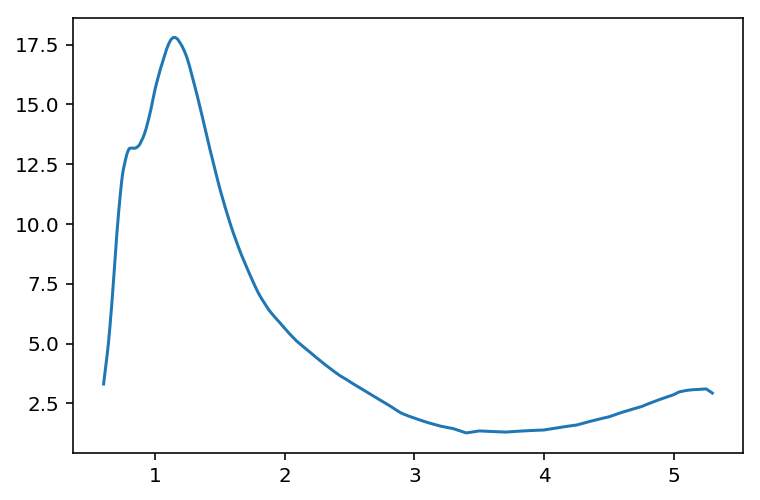

In [41]:
bg = fits.getdata(bg_path)
plt.plot(bg['WAVELENGTH'], bg['extracted_bg_only'])